# 라이브러리 로드

In [2]:
# 기본 
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt

# 딥러닝
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# 코드 실행 속도 측정
import time # time 라이브러리 import

# 데이터 로드 및 확인

In [3]:
## Read PM2.5 data at June 05, 2019
df1 = pd.read_csv('.\covariate0605.csv')
df2 = pd.read_csv('.\pm25_0605.csv')

## 변수설명: meteorological variables(기상학 변수)
총 7,706개의 그리드(32x32 km)에서 측정된 자료(2019년 6월 5일) from NARR
 - `long`: 경도
 - `lat`: 위도
 - `prec`: 누적 총 강수량
 - `temp`: 기온
 - `pres`: surface pressure, 기압?
 - `rh`:  relative humidity at 2 m
 - `uwind`: u-component of wind
 - `vwind`: v-component of wind at 10 m
 

In [4]:
df1.head(5)

,Unnamed: 0,long,lat,prec,temp,pres,rh,uwind,vwind
0,41242,-69.111491,47.386418,0.283942,278.605652,96929.570312,79.589600,4.852976,1.651037
1,41243,-68.736976,47.244262,0.276129,278.605652,97242.070312,79.589600,4.470163,1.646155
2,41244,-68.364554,47.100850,0.276129,279.753113,98692.070312,75.652100,4.477976,1.624670
3,41245,-67.994227,46.956192,0.604254,280.398621,98792.070312,77.417725,4.096140,1.615881
4,41589,-69.318835,47.131182,0.174567,278.424988,96567.070312,77.456787,5.140085,1.481116


## 변수설명: $PM_{2.5}$
총 841개의 관측소에서 관측된 자료
 - PM25: 일평균(2019년 6월 5일) 미세먼지 $PM_{2.5}$관측 자료
 - PM_class: 

In [5]:
df2.head(5)

,Unnamed: 0,Longitude,Latitude,PM25,PM_class
0,1,-80.482778,25.471944,4.400000,1
1,2,-80.215556,25.794222,4.929167,1
2,3,-97.493830,25.892518,8.213636,1
3,4,-80.326389,25.941944,4.100000,1
4,5,-80.256944,26.053889,4.992754,1


In [6]:
#  기상학 자료의 위경도를 제외한 공변량만 추출
covariates = df1.values[:, 3:]
covariates.shape

(7706, 6)

In [7]:
# PM2.5 자료의 위경도만 추출
aqs_lonlat=df2.values[:,[1,2]]
aqs_lonlat.shape

(842, 2)

## 데이터 위치 시각화

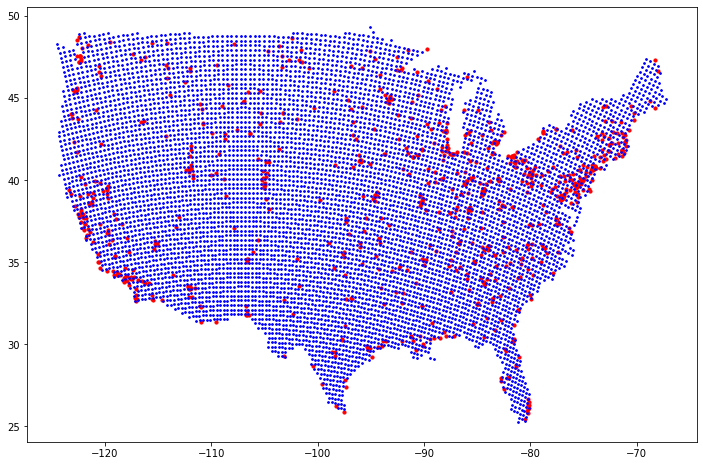

In [8]:
# PM2.5 data와 meteorogical data를 지도위에 동시에 표시

# 그림 크기 설정 (가로 12인치, 세로 8인치)
plt.figure(figsize=(12, 8))

plt.scatter(aqs_lonlat[:,0], aqs_lonlat[:,1], c='r', s=10) # PM2.5 data
plt.scatter(df1.values[:,1], df1.values[:,2], c='b', s=3) # meteorogical data
plt.show()

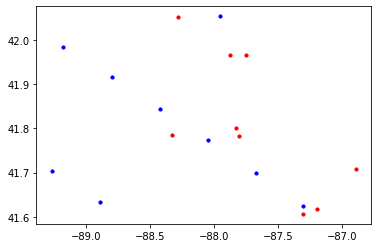

In [9]:
# "시카고"의 PM2.5 data와 meteorogical data를 지도위에 동시에 표시

## PM2.5 data에서 시카고 지역의 데이터만 추출
chicago_pm25 = df2[(df2['Latitude'] > 41.6) & (df2['Latitude'] < 42.1) & (df2['Longitude'] > -89.5) & (df2['Longitude'] < -86.5)]
chicago_pm25 = chicago_pm25.values[:,[1,2]]

## 기상학 data에서 시카고 지역의 데이터만 추출
chicago_met = df1[(df1['lat'] > 41.6) & (df1['lat'] < 42.1) & (df1['long'] > -89.5) & (df1['long'] < -86.5)]
chicago_met = chicago_met.values[:,[1,2]]

## PM2.5 data와 기상학 data를 지도위에 동시에 표시
plt.scatter(chicago_pm25[:,0], chicago_pm25[:,1], c='r', s=10) # PM2.5 data
plt.scatter(chicago_met[:,0], chicago_met[:,1], c='b', s=10) # meteorogical data
plt.show()


# 데이터 병합

## Pair the long and lat based on the nearest neighbor
 Since the coordinates from NARR and those from stations are not identical and some of stations are too close to each other, we keep the spatial resolution of NARR and average the PM25 measurements of nearby monitoring stations in the same grid cell.

 After the matching, 604 grid cells remain for the model training.

> 자료의 매칭을 하고 나면 남는 7,706-604=7,102개의 위치(기상학 자료의 해상도를 유지)에서 $PM_{2.5}$ 값의 예측이 이번 Application의 목표입니다.

자료의 매칭방법은 1-NN방법 입니다. 

In [10]:
from scipy import spatial

# 기상학 data에서 좌표정보 추출
near = df1.values[:,[1,2]] 

tree = spatial.KDTree(list(zip(near[:,0].ravel(), near[:,1].ravel())))
    # ravel() : 다차원 배열을 1차원으로 변경
    # zip() : 두개의 리스트를 하나의 튜플로 만들어줌
    ## ex) zip([1,2,3],[4,5,6]) => [(1,4),(2,5),(3,6)]
    # list() : 튜플을 리스트로 변경
    # spatial.KDTree() : KDTree 생성, 이는 다차원에서 NN을 수행해주는 함수

tree.data # KDTree의 데이터: 즉 생성된 KDTree의 좌표정보

array([[-69.11149122,  47.38641834],
       [-68.73697557,  47.24426247],
       [-68.36455383,  47.10084972],
       ...,
       [-98.12177313,  26.12568696],
       [-97.82368098,  26.09304595],
       [-97.52588153,  26.05934002]])

In [11]:
idx = tree.query(aqs_lonlat)[1] 
    # KD 트리에서 aqs_lonlat(미세먼지 관측소)과 가장 가까운 기상학 데이터를 찾습니다.
    # tree.query(aqs_lonlat)[1]은 최근접 이웃의 "인덱스"를 반환합니다.
    # tree.query(aqs_lonlat)[0]은 최근접 이웃과의 "거리"를 반환합니다.
    # 즉, 가장 가까운 기상학 데이터의 인덱스를 반환합니다.

In [12]:
# 좀 더 살펴보기
unique_indices = np.unique(tree.query(aqs_lonlat)[1])
unique_indices.shape
    # 특정 PM2.5 관측소들이 모여있어 가장 가까운 기상 데이터 좌표가 중복될 수 있습니다.
    # 밑의 그림을 통해 더 자세히 살펴볼 수 있음.

(605,)

In [13]:
# idx에서 중복이 발생한 인덱스 저장
duplicated_idx = []

for i in idx:
    if np.sum(idx == i) > 1:
        duplicated_idx.append(i)

duplicated_idx = np.array(duplicated_idx)
duplicated_idx.shape


(368,)

In [14]:
duplicated_idx

array([7549, 7549, 7512, 7512, 7512, 7512, 6798, 6798, 7503, 7503, 7459,
       7298, 7459, 7298, 6468, 6468, 7224, 7224, 7177, 7177, 5794, 5794,
       7003, 7003, 6551, 6551, 6012, 6012, 6012, 6012, 5786, 6696, 5786,
       5323, 6696, 5786, 6580, 5323, 6580, 6596, 6595, 6596, 6596, 6595,
       6595, 6595, 6485, 6485, 6363, 6363, 5429, 6139, 5429, 6139, 6252,
       6139, 6139, 6252, 6141, 6141, 6139, 5429, 6139, 6141, 6141, 6139,
       6026, 6026, 5063, 5063, 5561, 5561, 5063, 5948, 5948, 5412, 5413,
       5413, 5948, 5948, 5412, 4452, 4452, 5565, 5565, 5565, 5627, 5627,
       4568, 4067, 4568, 4442, 4442, 4442, 4442, 4067, 5460, 5459, 5459,
       5460, 5340, 5159, 5340, 5159, 5159, 4836, 4836, 4842, 4842, 3165,
       4714, 3165, 4590, 4842, 4714, 4590, 4590, 3031, 4781, 3031, 4336,
       4781, 4336, 4335, 4335, 4335, 4208, 4209, 4208, 4208, 3916, 3916,
       4209, 3789, 3660, 3660, 3660, 3660, 3149, 3149, 3789, 3660, 3276,
       3276, 3908, 3953, 3953, 3954, 3908, 3908, 39

In [15]:
# 중복이 가장 많은 기상 관측소 찾기
unique, counts = np.unique(duplicated_idx, return_counts=True)
most_freq = unique[np.argmax(counts)]
    # unique : 중복된 인덱스 값의 고유한 값들이 저장되어 있음음
    # return_counts=True : 각 고유값이 배열에서 몇 번 발생하는지 세는 주는 옵션
    # np.argmax(counts) : 중복된 횟수 중 가장 큰 값의 인덱스를 반환합니다.

In [16]:
# 중복이 가장 많은 기상 관측소의 좌표
## Recall: near은 기상학 데이터의 좌표를 저장하고 있습니다.
most_freq_x, most_freq_y= near[most_freq]
most_freq_x, most_freq_y

(-73.8973198485606, 40.6649319147812)

In [17]:
# idx에서 중복이 가장 많았던 기상소와 pm2.5 관측소의 거리중 가장 큰 값 찾기
most_pm = aqs_lonlat[idx == most_freq]
most_met = near[most_freq]

d = np.max(np.sqrt(np.sum((most_pm - most_met)**2, axis=1)))
# 반올림
d = np.round(d, 1)


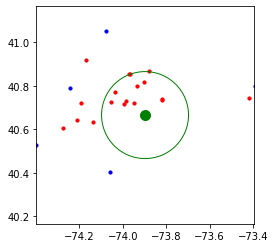

In [18]:
# 중복이 가장 많은 기상 관측소의 좌표를 찾아서 표시
plt.scatter(aqs_lonlat[:,0], aqs_lonlat[:,1], c='r', s=10) # PM2.5 data
plt.scatter(df1.values[:,1], df1.values[:,2], c='b', s=10) # meteorogical data
plt.scatter(most_freq_x, most_freq_y, c='g', s=100) # 중복이 가장 많은 기상 관측소
#  most_freq_x, most_freq_y을 중심으로 한 원 그리기
circle = plt.Circle((most_freq_x, most_freq_y), d, color='g', fill=False)
plt.gca().add_artist(circle)

# 축의 비율을 정사각형으로 설정
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(most_freq_x-0.5, most_freq_x+0.5)
plt.ylim(most_freq_y-0.5, most_freq_y+0.5)
plt.show()


In [19]:
df2_new = df2.assign(neighbor = idx)
    # assign() : 새로운 열을 추가
    # df2(PM data)에 neighbor 열을 추가하고, 그 값은 idx로 한다.
    # recall: idx는 PM 자료 기준으로 가장 가까운 기상학 데이터의 인덱스를 저장하고 있습니다.

df_pm25 = df2_new.groupby('neighbor')['PM25'].mean()
    # groupby() : 특정 열을 기준으로 그룹화 
    # mean() : 평균값을 구함
    # neighbor를 기준으로 PM의 평균값을 구해서 df_pm25에 저장

df_pm25_class = pd.cut(df_pm25, bins=[-0.1,12.1,35.5],labels=["0","1"])
    # cut() : 구간을 나눔
    # bins : 나눌 구간
    # labels : 구간에 대한 이름
    # PM25값을 기준으로 구간을 나누고, 0과 1로 분류함. 이를 df_pm25_class에 저장
    ## 자세히 쓰자면, -0.1~12.1은 0으로, 12.1~35.5는 1로 분류함.
    ### cut 기준을 0부터 해서 오류가 발생함. -0.1부터 시작하면 오류가 발생하지 않음.

idx_new = df_pm25.index.values
    # df_pm25의 인덱스를 idx_new에 저장
    # 병합후 남은 기상학 관측소의 인덱스를 저장
    # 이제 해당 기상학 관측소의 좌표를 사용하여 모형을 학습 시킬 것임.

위의 데이터 병합 과정을 설명해 보겠습니다. 다음과 같이 $i^{th}$ 기상학 관측소와 $i_{1}, \ldots, i_{k}$ 개의 PM 관측소가 가장 가까운 그룹으로 묶여있다고 가정하겠습니다. 여기서 $a_1, \ldots, a_k$를 각 PM 관측소에서 관측된 $PM_{2.5}$ 값이라고 하겠습니다.

$$
\begin{pmatrix}
i 기상학 자료 & i_1 PM 관측소 & a_1\\
 & i_2 PM 관측소 & a_2 \\
 & \vdots  & \\
 & i_k PM 관측소 & a_k
\end{pmatrix}
$$

$$
\rightarrow
$$

$$
\begin{pmatrix}
 & 미세먼지 농도 \\
i 기상학 자료 & (a_1 + \ldots + a_k)/k
\end{pmatrix}
$$



추가로 위의 셀에서 df_pm_class 변수를 생성한 이유는 risk of high pollution $\mathbb{P}(PM_{2.5} > 12 \, \mu g / m^3)$을 예측하기 위함입니다... 추후 사용될 예정

In [20]:
idx_new.shape

(605,)

In [21]:
# 학습에 사용될 PM2.5 데이터와 PM2.5 클래스 데이터를 각각 z와 z_class에 저장
pm25 = df_pm25.values
pm25_class = np.array(df_pm25_class.values, dtype=int)
z = pm25[:,None]
z_class = pm25_class[:,None]

In [22]:
# basis function을 구축하기 위해 좌표를 정규화
lon = df1.values[:,1]
lat = df1.values[:,2]
normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
normalized_lat = (lat-min(lat))/(max(lat)-min(lat))

# 데이터의 개수를 저장합니다.
N = lon.shape[0]

In [23]:
N

7706

# 반응변수 EDA

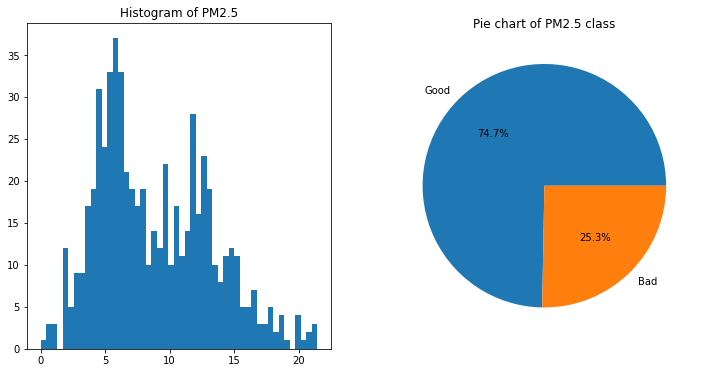

In [24]:
# z의 히스토그램 및 z_class 파이차트 그리기
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(z, bins=50)
plt.title('Histogram of PM2.5')

plt.subplot(1, 2, 2)
plt.pie([np.sum(z_class==0), np.sum(z_class==1)], labels=['Good', 'Bad'], autopct='%1.1f%%')
plt.title('Pie chart of PM2.5 class')

plt.show()

# Basis 함수 설정

## Wendland basis function

Let $\{\mathbf{u}_j\}, j=1,2, \ldots, m$ be a  rectangular grid of points (or node points in the radial basis function terminology).

$$
\phi\left(\left\|\mathbf{s}-\mathbf{u}_j\right\| / \theta\right) = \phi(d) =
\begin{cases}
    (1-d)^6\left(35 d^2+18 d+3\right) / 3, & d \in[0,1] \\ 0, & \text { otherwise. }
\end{cases}
$$

where the scale parameter $\theta$ is set to be 2.5 times the associated knots spacing
 according to Nychka et al. (2015).

In [25]:
# Set the number of basis functions
num_basis = [10**2,19**2,37**2] # 2차원 basis라서 제곱

# Set the knots for the basis functions: 3 sets of knots for 3 different resolutions
knots_1dx = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
knots_1dy = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]


# Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis))) # N x sum(num_basis) 크기의 0 행렬 생성

# Resolution 단위 반복문
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5 # scale parameter of the Wendland kernel
    knots_x, knots_y = np.meshgrid(knots_1dx[res],knots_1dy[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten())) # 좌표로 변환

    # 각 단계별 resolution에 대한 Wendland kernel 계산
    for i in range(num_basis[res]):
        d = np.linalg.norm(np.vstack((normalized_lon, normalized_lat)).T - knots[i,:], axis=1)/theta
            # np.vstack() : 배열을 세로로 합침. 즉, 정규화된 좌표를 2열 짜리 행렬로 변환
            # np.linalg.norm() : 벡터의 길이를 계산. 여기서는 정규화된 좌표와 knots 사이의 거리를 계산(유클리드 거리)

        # Wendland kernel 값 계산
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0

    basis_size = basis_size + num_basis[res]

In [26]:
knots

array([[0.        , 0.        ],
       [0.02777778, 0.        ],
       [0.05555556, 0.        ],
       ...,
       [0.94444444, 1.        ],
       [0.97222222, 1.        ],
       [1.        , 1.        ]])

In [27]:
np.vstack((normalized_lon, normalized_lat)).T

array([[0.96725502, 0.91812118],
       [0.97380125, 0.9122209 ],
       [0.98031088, 0.90626846],
       ...,
       [0.46017898, 0.03567999],
       [0.46538939, 0.03432521],
       [0.47059468, 0.03292622]])

In [28]:
np.vstack((normalized_lon, normalized_lat)).T.shape

(7706, 2)

In [29]:
knots[1,:].shape

(2,)

In [30]:
np.vstack((normalized_lon, normalized_lat)).T - knots[1,:]
    # 위 계산은 빼주는 2차원 벡터를 N개 쌓아서 N x 2 행렬을 만들고, 이를 빼주는 행렬 연산을 수행 해 줍니다.

array([[0.93947725, 0.91812118],
       [0.94602347, 0.9122209 ],
       [0.9525331 , 0.90626846],
       ...,
       [0.4324012 , 0.03567999],
       [0.43761161, 0.03432521],
       [0.4428169 , 0.03292622]])

In [31]:
np.linalg.norm(np.vstack((normalized_lon, normalized_lat)).T - knots[1,:], axis=1)/theta

array([19.44138725, 19.45007977, 19.45871801, ...,  6.42128767,
        6.49654492,  6.57178235])

위 코드 블럭들을 이해하자면 $\phi$ 행렬의 $i^{th}$ 열는 $i^{th}$ knot 기준으로 모든 데이터의 정규화된 위치와의 basis function value가 저장. 이때, $i^{th}$ knot와 데이터와 거리가 멀어 해당 knot에서 basis function값이 모두 0이 될 수 있습니다. 

특정 열($i_*^{th}$)이 모두 0값을 가진다는 것은, 모든 데이터 포인트에서 해당 basis function의 값이 0이므로 DeepKriging 모형에서 그 embeding node는 항상 0이므로 학습에 방해가 됩니다. 왜냐하면 $j^{th}$ 행이 모형 학습시 $j^{th}$ 데이터에 대한 Embeding layer가 되기 때문에, 모든 $j^{th}$ 데이터에 대해 $i_*^{th}$ node의 값이 0인 상태가 됩니다. 

따라서, $i_*^{th}$ node를 통한 forward가 진행되지 않고, backpropagation에 대한 update를 전혀 주지 않게 됩니다. 오히려, 모델의 모수 개수만 늘려 효율성만 떨어뜨리는 결과를 야기하게 될 가능성이 높을것으로 보입니다.

In [32]:
num_basis

[100, 361, 1369]

In [33]:
## Romove the all-zero columns
idx_zero = np.array([], dtype=int)
for i in range(phi.shape[1]):
    if sum(phi[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

In [34]:
phi_reduce = np.delete(phi,idx_zero,1)
print(phi.shape)
print(phi_reduce.shape)

(7706, 1830)
(7706, 1486)


In [35]:
phi_reduce

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.91492736e-08, 8.28326623e-02, 8.02443262e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.55982500e-10, 6.80625788e-02, 7.91566710e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.52160967e-02, 7.74831110e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

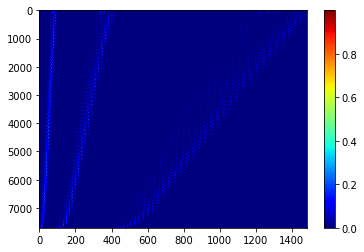

In [36]:
# phi_reduce 시각화, 색상 팔레트 변경
plt.imshow(phi_reduce, aspect='auto',cmap='jet')
plt.colorbar()
plt.show()


In [37]:
# Recall) idx_new는 자료 병합 후 기상학 관측소의 인덱스를 의미합니다.
phi_obs = phi_reduce[idx_new,:]
s_obs = np.vstack((normalized_lon[idx_new], normalized_lat[idx_new])).T
X = covariates[idx_new,:]
    # phi_obs : 학습에 사용될 기상학 관측소의 basis function 값 행렬
    # s_obs : 학습에 사용될 기상학 관측소의 좌표
    # X : 학습에 사용될 기상학 관측소의 공변량

# 딥러닝을 위해 입력변수를 정규화
normalized_X = X

for i in range(X.shape[1]):
    normalized_X[:,i] = (X[:,i]-min(X[:,i]))/(max(X[:,i])-min(X[:,i]))

# 학습에 사용되는 기상학 관측소의 개수(데이터의 개수)
N_obs = X.shape[0]

In [38]:
N_obs

605

In [39]:
s_obs

array([[0.98031088, 0.90626846],
       [0.98309348, 0.88976228],
       [0.97423795, 0.81472205],
       ...,
       [0.46866546, 0.09037756],
       [0.46017898, 0.03567999],
       [0.47059468, 0.03292622]])

## The risk of high pollution $\mathbb{I}(PM_{2.5} > 12 \, \mu g / m^3)$ class 나누기

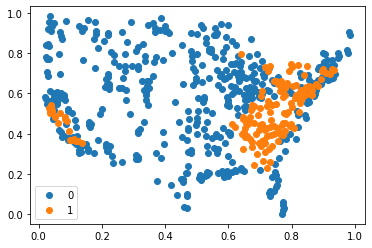

In [40]:
# scatter plot of the circles dataset with points colored by class
from numpy import where
from matplotlib import pyplot

# select indices of points with each class label
for i in range(2):
	samples_ix = where(z_class[:,0] == i)
	pyplot.scatter(s_obs[samples_ix, 0], s_obs[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

## Save the prepocessed data for Kriging

In [41]:
## Save the prepocessed data for Kriging
z_log = np.log(z)
kriging = np.concatenate((s_obs, normalized_X, z, z_class, z_log), axis=1)

# ###### 아래 코드는 CV결과에 의심되는 것이 있어 데이터의 순서를 뒤집는 코드입니다. ######
# # 데이터프레임으로 만들기
# kriging = pd.DataFrame(kriging)
# # 순서 뒤집기
# kriging = kriging.iloc[::-1].reset_index(drop=True)
# # 배열로 돌리기
# kriging = kriging.values
# ###### 뒤집기 끝 ########

traindf=pd.DataFrame(kriging)
traindf.to_csv('.\kriging.csv')

## Save the prepocessed data for FRK(좌표 정규화 x)
s_obs2 = np.vstack((lon[idx_new], lat[idx_new])).T
kriging2 = np.concatenate((s_obs2, X, z, z_class, z_log), axis=1)

# ###### 아래 코드는 CV결과에 의심되는 것이 있어 데이터의 순서를 뒤집는 코드입니다. ######
# # 데이터프레임으로 만들기
# kriging2 = pd.DataFrame(kriging2)
# # 순서 뒤집기
# kriging2 = kriging2.iloc[::-1].reset_index(drop=True)
# # 배열로 돌리기
# kriging2 = kriging2.values
# ###### 뒤집기 끝 ########

C:\Users\admin\AppData\Local\Temp\ipykernel_552\2455032538.py:2: RuntimeWarning: divide by zero encountered in log
  z_log = np.log(z)


In [42]:
## Save the prepocessed data for Kriging
z_log = np.log(z)
kriging = np.concatenate((s_obs, normalized_X, z, z_class, z_log), axis=1)
traindf=pd.DataFrame(kriging)
traindf.to_csv('.\kriging.csv')

## Save the prepocessed data for FRK(좌표 정규화 x)
s_obs2 = np.vstack((lon[idx_new], lat[idx_new])).T
kriging2 = np.concatenate((s_obs2, X, z, z_class, z_log), axis=1)
traindf2=pd.DataFrame(kriging2)
traindf2.to_csv('.\kriging2.csv')

C:\Users\admin\AppData\Local\Temp\ipykernel_552\1516451194.py:2: RuntimeWarning: divide by zero encountered in log
  z_log = np.log(z)


# Load the useful functions

> 주의: deep_model 함수에 model.compile과 model.fit이 내장되어 있습니다.

`complile()` Method
 - `loss`: 모형의 학습에 사용되는 손실함수를 정의합니다.
 - `optimizer`: 함수 최적화 시 사용할 방법을 선택합니다. 예를 들어, adam, sgd 등이 있겠습니다.
 - `metrics`: 모델을 학습시키고 평가할 때 사용하는 평가 지표

In [43]:
# def deep_model(model, X_train, y_train, X_valid, y_valid, data_type):
#     '''
#     Function to train a multi-class model. The number of "epochs" and 
#     "batch_size" are set by the constants at the top of the
#     notebook. 
    
#     Parameters:
#         model : model with the chosen architecture
#         X_train : training features
#         y_train : training target
#         X_valid : validation features
#         Y_valid : validation target
#     Output:
#         model training history
#     '''
#     if data_type == 'continuous':
#         model.compile(optimizer='adam'
#                       , loss='mse'
#                       , metrics=['mse','mae'])
#     if data_type == 'discrete':
#         model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     history = model.fit(X_train
#                        , y_train
#                        , epochs=NB_START_EPOCHS
#                        , batch_size=BATCH_SIZE
#                        , validation_data=(X_valid, y_valid)
#                        , verbose=0)
#     return history

# def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
#     '''
#     Function to test the model on new data after training it
#     on the full training data with the optimal number of epochs.
    
#     Parameters:
#         model : trained model
#         X_train : training features
#         y_train : training target
#         X_test : test features, NOT VALIDATION FEATURES
#         y_test : test target, NOT VALIDATION TARGET
#         epochs : optimal number of epochs
#     Output:
#         test accuracy and test loss
#     '''
#     model.fit(X_train
#               , y_train
#               , epochs=epoch_stop
#               , batch_size=BATCH_SIZE
#               , verbose=0)
#     results = model.evaluate(X_test, y_test, verbose=0)
#     return results
    
# def optimal_epoch(model_hist):
#     '''
#     Function to return the epoch number where the validation loss is
#     at its minimum
    
#     Parameters:
#         model_hist : training history of model
#     Output:
#         epoch number with minimum validation loss
#     '''
#     min_epoch = np.argmin(model_hist.history['val_loss']) + 1
#     return min_epoch

논문의 저자가 제공하는 코드는 CV 진행시 Validation data를 이용하여 최적의 에포크 값을 찾습니다. 이 방법이 부당하다고 느껴질 수 있기 때문에, 다음과 같이 코드를 수정하였습니다.

 - 데이터를 train / validation으로 나눕니다.
 - 그 후 최적의 epoch를 찾기 위해, train을 train_tune / test_tune으로 6:4다시 나눕니다.

이후 나누어진 tune 데이터들을 사용하여 최적의 epoch값을 찾아 valiation을 진행 합니다.

> 주의: 여기서 데이터를 나눌때 공간적 상관성을 고려하지 못하고 랜덤하게 나누게 됩니다.

In [44]:
def deep_model(model, X_train, y_train, data_type):
    '''
    Function to train a multi-class model. The number of "epochs" and 
    "batch_size" are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        Y_valid : validation target
    Output:
        model training history
    '''
    if data_type == 'continuous':
        model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=['mse','mae'])
    if data_type == 'discrete':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # train데이터를 7:3로 나눕니다.
    X_train_tune, X_valid_tune, y_train_tune, y_valid_tune = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

    history = model.fit(X_train_tune
                       , y_train_tune
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid_tune, y_valid_tune)
                       , verbose=0)
    return history

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features, NOT VALIDATION FEATURES
        y_test : test target, NOT VALIDATION TARGET
        epochs_stop : optimal number of epochs(이때 학습이 중단됩니다.)
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test, verbose=0)
    return results
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    return min_epoch

# Hyperparameter Tuning

딥러닝 모형의 히든 노드 개수를 튜닝하기 위해 `kerastuner`를 사용합니다. 해당 방법은 정해진 노드의 개수, 학습률에서 적당히 grid 서치 해주어 validation error가 가장 낮은 조합을 찾아줍니다.

In [45]:
import tensorflow as tf
from tensorflow import keras

import IPython

# !pip install -q -U keras-tuner

import kerastuner as kt

C:\Users\admin\AppData\Local\Temp\ipykernel_552\1470784104.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [46]:
# hyperparameter tuning을 위해 입력변수 생성
p = covariates.shape[1] + phi_reduce.shape[1]

In [47]:
def model_builder(hp):
  model_hp = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 100 ~ 500
  hp_layer_1 = hp.Int('layer_1', min_value = 100, max_value = 500, step = 50)
  # hp_layer_2 = hp.Int('layer_2', min_value = 100, max_value = 500, step = 50)
  # hp_layer_3 = hp.Int('layer_3', min_value = 100, max_value = 500, step = 50)

  model_hp.add(Dense(units = hp_layer_1, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
  model_hp.add(Dropout(rate=0.5))
  model_hp.add(BatchNormalization())

  model_hp.add(Dense(units = hp_layer_1, activation='relu'))
  model_hp.add(Dropout(rate=0.5))
  model_hp.add(BatchNormalization())

  model_hp.add(Dense(units = hp_layer_1, activation='relu'))
  model_hp.add(Dropout(rate=0.5))
  model_hp.add(BatchNormalization())

  model_hp.add(Dense(units = hp_layer_1, activation='relu'))
  model_hp.add(Dropout(rate=0.5))
  model_hp.add(BatchNormalization())

  model_hp.add(Dense(units = hp_layer_1, activation='relu'))
  model_hp.add(BatchNormalization())
  model_hp.add(Dense(1, activation='relu'))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.1 to 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2]) 

  model_hp.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                      loss = keras.losses.MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error"), 
                      metrics = ['mse'])

  return model_hp

tuner = kt.Hyperband(hypermodel = model_builder,
                     objective = 'val_mse', 
                     max_epochs = 20,
                     factor = 2,
                    #  directory = 'my_dir',
                     project_name = 'tune_1')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
# 입력변수 정의
inputs = np.hstack((normalized_X, phi_obs)) # DeepKriging을 위한 입력변수

# 타겟변수 정의
targets = z
targets_class = z_class

# train데이터를 7:3로 나눕니다.
X_tra, X_val, y_tra, y_val = train_test_split(inputs, targets, test_size=0.3, random_state=0)

In [49]:
tuner.search(X_tra, y_tra, epochs = 30, validation_data = (X_val, y_val), callbacks = [stop_early])

Trial 8 Complete [00h 00m 04s]
val_mse: 52.62607192993164

Best val_mse So Far: 13.90993881225586
Total elapsed time: 00h 00m 30s


In [50]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the  layers is {best_hps.get('layer_1')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the  layers is 100.



# CV 수행

In [51]:
from sklearn.model_selection import KFold
NB_START_EPOCHS = 400  # Number of epochs(논문 제시값 200)
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent

### [CV] All Methods

In [52]:
# np.random.seed(123) # 랜덤 시드 고정

# fold cross-validation
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 25)
    # KFold() : K-Folds cross-validator 생성
    # n_splits : 폴드 수
    # shuffle : 데이터를 분할하기 전 무작위로 섞을지 여부
    # random_state : 데이터를 무작위로 섞을 때 사용하는 난수 발생기 시드

# 입력변수 정의
inputs = np.hstack((normalized_X, phi_obs)) # DeepKriging을 위한 입력변수
inputs_base = np.hstack((normalized_X, s_obs)) # Baseline DNN을 위한 입력변수
inputs_nx = phi_obs # DK NO X를 위한 입력변수

# 타겟변수 정의
targets = z
targets_class = z_class

# 성능 비교 값들 받을 리스트 생성
mse_per_fold = []
mse_per_fold_deep = []
mse_per_fold_wide = []
mse_per_fold_base = []
mse_per_fold_nx = []
mse_per_fold_t = []

mae_per_fold = []
mae_per_fold_deep = []
mae_per_fold_wide = []
mae_per_fold_base = []
mae_per_fold_nx = []
mae_per_fold_t = []

acc_per_fold = []
acc_per_fold_deep = []
acc_per_fold_wide = []
acc_per_fold_base = []
acc_per_fold_nx = []
acc_per_fold_t = []

**주의: 밑의 CV 코드 블럭 실행 시간 약 180분(연구실 컴퓨터 기준)/60분(자취방 기준)**

실행 시간을 줄이고 싶으면 `NB_START_EPOCHS = 300`값을 줄이거나
밑의 `model_optim = optimal_epoch(history)`코드에서 `optimal_epoch(history_...)` 부분을 작은 숫자로 바꾸어 돌리면 됩니다.

In [53]:
# 폴드 번호 지정
fold_no = 1

for train_idx, test_idx in kfold.split(inputs, targets):
        # kfold.split() : 각 폴드에 대해 학습용, 테스트용 인덱스를 생성
    print('------------------------------------------------------------------------')
    print(f'Fold: {fold_no} ...')

    ##### Model for continuous data #####
    # 매 폴드마다 가중치를 초기화 해야 하므로 모형을 매 폴드마다 새로 정의!
    
    # 모델 정의를 위해 입력변수의 차원을 정의
    p = covariates.shape[1] + phi_reduce.shape[1]
    p_base = covariates.shape[1] + s_obs.shape[1]
    p2 =  phi_reduce.shape[1] # Embedding layer만 사용

    # DeepKriging model for continuous data
    model = Sequential()
    model.add(Dense(100, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='relu'))

    # Deeper DeepKriging model for continuous data
    model_deep = Sequential()
    model_deep.add(Dense(100, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
    model_deep.add(Dropout(rate=0.5))
    model_deep.add(BatchNormalization())
    model_deep.add(Dense(100, activation='relu'))
    model_deep.add(Dropout(rate=0.5))
    model_deep.add(Dense(100, activation='relu'))
    model_deep.add(BatchNormalization())
    model_deep.add(Dense(100, activation='relu'))
    model_deep.add(Dropout(rate=0.5))
    model_deep.add(Dense(100, activation='relu'))
    model_deep.add(BatchNormalization())
    model_deep.add(Dense(1, activation='relu'))
    
    # Wider DeepKriging model for continuous data
    model_wide = Sequential()
    model_wide.add(Dense(200, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
    model_wide.add(Dropout(rate=0.5))
    model_wide.add(BatchNormalization())
    model_wide.add(Dense(200, activation='relu'))
    model_wide.add(Dropout(rate=0.5))
    model_wide.add(Dense(200, activation='relu'))
    model_wide.add(BatchNormalization())
    model_wide.add(Dense(1, activation='relu'))

    # Baseline DNN model for continuous data
    model_base = Sequential()
    model_base.add(Dense(100, input_dim = p_base, kernel_initializer='he_uniform', activation='relu'))
    model_base.add(Dropout(rate=0.5))
    model_base.add(BatchNormalization())
    model_base.add(Dense(100, activation='relu'))
    model_base.add(Dropout(rate=0.5))
    model_base.add(Dense(100, activation='relu'))
    model_base.add(BatchNormalization())
    model_base.add(Dense(1, activation='relu'))

    # DeepKriging NO X model for continuous data
    model_nx = Sequential()
    model_nx.add(Dense(100, input_dim = p2,  kernel_initializer='he_uniform', activation='relu'))
    model_nx.add(Dropout(rate=0.5))
    model_nx.add(BatchNormalization())
    model_nx.add(Dense(100, activation='relu'))
    model_nx.add(Dropout(rate=0.5))
    model_nx.add(Dense(100, activation='relu'))
    model_nx.add(BatchNormalization())
    model_nx.add(Dense(1, activation='relu'))

    # DK tuned model for continuous data
    model_t = Sequential()
    model_t.add(Dense(best_hps.get('layer_1'), input_dim = p, kernel_initializer='he_uniform', activation='relu'))
    model_t.add(Dropout(rate=0.5))
    model_t.add(BatchNormalization())
    model_t.add(Dense(best_hps.get('layer_1'), activation='relu'))
    model_t.add(Dropout(rate=0.5))
    model_t.add(BatchNormalization())
    model_t.add(Dense(best_hps.get('layer_1'), activation='relu'))
    model_t.add(Dropout(rate=0.5))
    model_t.add(BatchNormalization())
    model_t.add(Dense(best_hps.get('layer_1'), activation='relu'))
    model_t.add(Dropout(rate=0.5))
    model_t.add(BatchNormalization())
    model_t.add(Dense(best_hps.get('layer_1'), activation='relu'))
    model_t.add(BatchNormalization())
    model_t.add(Dense(1, activation='relu'))

    ##### Model for categorical data #####  
    
    # DeepKriging model for categorical data
    model_class = Sequential()
    model_class.add(Dense(100, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
    model_class.add(Dropout(rate=0.5))
    model_class.add(BatchNormalization())
    model_class.add(Dense(100, activation='relu'))
    model_class.add(Dropout(rate=0.5))
    model_class.add(Dense(100, activation='relu'))
    model_class.add(BatchNormalization())
    model_class.add(Dense(1, activation='sigmoid'))

    # Deeper DeepKriging model for categorical data
    model_deep_class = Sequential()
    model_deep_class.add(Dense(100, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
    model_deep_class.add(Dropout(rate=0.5))
    model_deep_class.add(BatchNormalization())
    model_deep_class.add(Dense(100, activation='relu'))
    model_deep_class.add(Dropout(rate=0.5))
    model_deep_class.add(Dense(100, activation='relu'))
    model_deep_class.add(BatchNormalization())
    model_deep_class.add(Dense(100, activation='relu'))
    model_deep_class.add(Dropout(rate=0.5))
    model_deep_class.add(Dense(100, activation='relu'))
    model_deep_class.add(BatchNormalization())
    model_deep_class.add(Dense(1, activation='sigmoid'))
    
    # Wider DeepKriging model for categorical data
    model_wide_class = Sequential()
    model_wide_class.add(Dense(200, input_dim = p, kernel_initializer='he_uniform', activation='relu'))
    model_wide_class.add(Dropout(rate=0.5))
    model_wide_class.add(BatchNormalization())
    model_wide_class.add(Dense(200, activation='relu'))
    model_wide_class.add(Dropout(rate=0.5))
    model_wide_class.add(Dense(200, activation='relu'))
    model_wide_class.add(BatchNormalization())
    model_wide_class.add(Dense(1, activation='sigmoid'))

    # Baseline DNN model for categorical data
    model_base_class = Sequential()
    model_base_class.add(Dense(100, input_dim = p_base, kernel_initializer='he_uniform', activation='relu'))
    model_base_class.add(Dropout(rate=0.5))
    model_base_class.add(BatchNormalization())
    model_base_class.add(Dense(100, activation='relu'))
    model_base_class.add(Dropout(rate=0.5))
    model_base_class.add(Dense(100, activation='relu'))
    model_base_class.add(BatchNormalization())
    model_base_class.add(Dense(1, activation='sigmoid'))


    # DeepKriging NO X model for categorical data
    model_nx_class = Sequential()
    model_nx_class.add(Dense(100, input_dim = p2, kernel_initializer='he_uniform', activation='relu'))
    model_nx_class.add(Dropout(rate=0.5))
    model_nx_class.add(BatchNormalization())
    model_nx_class.add(Dense(100, activation='relu'))
    model_nx_class.add(Dropout(rate=0.5))
    model_nx_class.add(BatchNormalization())
    model_nx_class.add(Dense(100, activation='relu'))
    model_nx_class.add(Dropout(rate=0.5))
    model_nx_class.add(BatchNormalization())
    model_nx_class.add(Dense(100, activation='relu'))
    model_nx_class.add(Dropout(rate=0.5))
    model_nx_class.add(BatchNormalization())
    model_nx_class.add(Dense(100, activation='relu'))
    model_nx_class.add(BatchNormalization())
    model_nx_class.add(Dense(1, activation='sigmoid'))

    # DK tuned model for categorical data
    model_t_class = Sequential()
    model_t_class.add(Dense(best_hps.get('layer_1'), input_dim = p, kernel_initializer='he_uniform', activation='relu'))
    model_t_class.add(Dropout(rate=0.5))
    model_t_class.add(BatchNormalization())
    model_t_class.add(Dense(best_hps.get('layer_1'), activation='relu'))
    model_t_class.add(Dropout(rate=0.5))
    model_t_class.add(Dense(best_hps.get('layer_1'), activation='relu'))
    model_t_class.add(BatchNormalization())
    model_t_class.add(Dense(1, activation='sigmoid'))

    # 히스토리 초기화
    history = None
    history_deep = None
    history_wide = None
    history_base = None
    history_nx = None
    history_t = None

    history_class = None
    history_deep_class = None
    history_wide_class = None
    history_base_class = None
    history_nx_class = None
    history_t_class = None

    print(f'Complie and fitting for fold {fold_no} ...')

    # DeepKriging과 Baseline DNN을 학습(train set을 이용)하고 출력물들(history)을 저장
    ## deep_model() 함수를 이용하여 위에서 정의한 medel들을 complie 및 fitting 
    
    ### Continuous
    history = deep_model(model, inputs[train_idx], targets[train_idx,0:1]\
                              , 'continuous')
    # history_deep = deep_model(model_deep, inputs[train_idx], targets[train_idx,0:1]\
    #                           , 'continuous')                          
    history_wide = deep_model(model_wide, inputs[train_idx], targets[train_idx,0:1]\
                              , 'continuous')
    history_base = deep_model(model_base, inputs_base[train_idx], targets[train_idx,0:1]\
                              , 'continuous')
    history_nx = deep_model(model_nx, inputs_nx[train_idx], targets[train_idx,0:1]\
                              , 'continuous')
    history_t = deep_model(model_t, inputs[train_idx], targets[train_idx,0:1]\
                                , 'continuous')

    ### Classification
    history_class = deep_model(model_class, inputs[train_idx], targets_class[train_idx,0:1]\
                              , 'discrete')
    # history_deep_class = deep_model(model_deep_class, inputs[train_idx], targets_class[train_idx,0:1]\
    #                             , 'discrete')                          
    history_wide_class = deep_model(model_wide_class, inputs[train_idx], targets_class[train_idx,0:1]\
                              , 'discrete')
    history_base_class = deep_model(model_base_class, inputs_base[train_idx], targets_class[train_idx,0:1]\
                              , 'discrete')
    history_nx_class = deep_model(model_nx_class, inputs_nx[train_idx], targets_class[train_idx,0:1]\
                                , 'discrete')
    history_t_class = deep_model(model_t_class, inputs[train_idx], targets_class[train_idx,0:1]\
                                , 'discrete')
    
    # 위의 학습에서 얻은 history를 통해 최적의 epoch를 찾음
    ## 여기서 최적의 epoch는 validation loss가 최소가 되는 epoch를 의미
    model_optim = optimal_epoch(history)    
    # model_optim_deep = optimal_epoch(history_deep) 
    model_optim_wide = optimal_epoch(history_wide) 
    model_optim_base = optimal_epoch(history_base)
    model_optim_nx = optimal_epoch(history_nx)
    model_optim_t = optimal_epoch(history_t)

    model_optim_class = optimal_epoch(history_class)
    # model_optim_deep_class = optimal_epoch(history_deep_class)
    model_optim_wide_class = optimal_epoch(history_wide_class)
    model_optim_base_class = optimal_epoch(history_base_class)
    model_optim_nx_class = optimal_epoch(history_nx_class)
    model_optim_t_class = optimal_epoch(history_t_class)

    print(f'Test for fold {fold_no} ...')

    # 모형들의 예측결과를 저장(test set을 이용): continuous
    ## train set으로 모델을 학습하고 이를 통해 얻은 모델 파라미터로 test set을 예측

    result = test_model(model, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]\
                        , targets[test_idx,0:1], model_optim)
    # result_deep = test_model(model_deep, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]\
    #                     , targets[test_idx,0:1], model_optim_deep)
    result_wide = test_model(model_wide, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]\
                        , targets[test_idx,0:1], model_optim_wide)
    result_base = test_model(model_base, inputs_base[train_idx], targets[train_idx,0:1], inputs_base[test_idx]\
                             , targets[test_idx,0:1], model_optim_base)
    result_nx = test_model(model_nx, inputs_nx[train_idx], targets[train_idx,0:1], inputs_nx[test_idx]\
                        , targets[test_idx,0:1], model_optim_nx)
    result_t = test_model(model_t, inputs[train_idx], targets[train_idx,0:1], inputs[test_idx]
                        , targets[test_idx,0:1], model_optim_t)

    result_class = test_model(model_class, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_class)
    # result_deep_class = test_model(model_deep_class, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
    #                     , targets_class[test_idx,0:1], model_optim_deep_class)
    result_wide_class = test_model(model_wide_class, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_wide_class)
    result_base_class = test_model(model_base_class, inputs_base[train_idx], targets_class[train_idx,0:1], inputs_base[test_idx]\
                             , targets_class[test_idx,0:1], model_optim_base_class)
    result_nx_class = test_model(model_nx_class, inputs_nx[train_idx], targets_class[train_idx,0:1], inputs_nx[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_nx_class) 
    result_t_class = test_model(model_t_class, inputs[train_idx], targets_class[train_idx,0:1], inputs[test_idx]\
                        , targets_class[test_idx,0:1], model_optim_t_class)

    ## 결과 저장
    scores = result
    # scores_deep = result_deep
    scores_wide = result_wide
    scores_base = result_base
    scores_nx = result_nx  
    scores_t = result_t

    scores_class = result_class
    # scores_deep_class = result_deep_class
    scores_wide_class = result_wide_class
    scores_base_class = result_base_class
    scores_nx_class = result_nx_class
    scores_t_class = result_t_class

    # 결과값들을 리스트에 저장
     
    acc_per_fold.append(scores_class[1])
    # acc_per_fold_deep.append(scores_deep_class[1])
    acc_per_fold_wide.append(scores_wide_class[1])
    acc_per_fold_base.append(scores_base_class[1])
    acc_per_fold_nx.append(scores_nx_class[1])
    acc_per_fold_t.append(scores_t_class[1])

    mse_per_fold.append(scores[1])
    # mse_per_fold_deep.append(scores_deep[1])
    mse_per_fold_wide.append(scores_wide[1])
    mse_per_fold_base.append(scores_base[1])
    mse_per_fold_nx.append(scores_nx[1])
    mse_per_fold_t.append(scores_t[1])

    mae_per_fold.append(scores[2])
    # mae_per_fold_deep.append(scores_deep[2])
    mae_per_fold_wide.append(scores_wide[2])
    mae_per_fold_base.append(scores_base[2])
    mae_per_fold_nx.append(scores_nx[2])
    mae_per_fold_t.append(scores_t[2])

    fold_no = fold_no + 1 # fold_no 증가
    

------------------------------------------------------------------------
Fold: 1 ...
Complie and fitting for fold 1 ...
Test for fold 1 ...
------------------------------------------------------------------------
Fold: 2 ...
Complie and fitting for fold 2 ...
Test for fold 2 ...
------------------------------------------------------------------------
Fold: 3 ...
Complie and fitting for fold 3 ...
Test for fold 3 ...
------------------------------------------------------------------------
Fold: 4 ...
Complie and fitting for fold 4 ...
Test for fold 4 ...
------------------------------------------------------------------------
Fold: 5 ...
Complie and fitting for fold 5 ...
Test for fold 5 ...
------------------------------------------------------------------------
Fold: 6 ...
Complie and fitting for fold 6 ...
Test for fold 6 ...
------------------------------------------------------------------------
Fold: 7 ...
Complie and fitting for fold 7 ...
Test for fold 7 ...
--------------------

In [55]:
# 결과값들을 데이터프레임으로 변환
cv_result_py = pd.DataFrame({'Fold': np.arange(1, num_folds+1)
                            , 'MSE_DK': mse_per_fold
                            # / 'MSE_Deep': mse_per_fold_deep
                            , 'MSE_Wide': mse_per_fold_wide
                            , 'MSE_Baseline_DNN': mse_per_fold_base
                            , 'MSE_DK_NX': mse_per_fold_nx
                            , 'MSE_Tuner': mse_per_fold_t
                            , 'MAE_DK': mae_per_fold
                            # , 'MAE_Deep': mae_per_fold_deep
                            , 'MAE_Wide': mae_per_fold_wide
                            , 'MAE_Baseline_DNN': mae_per_fold_base
                            , 'MAE_DK_NX': mae_per_fold_nx
                            , 'MAE_Tuner': mae_per_fold_t
                            , 'Accuracy_DK': acc_per_fold
                            # , 'Accuracy_Deep': acc_per_fold_deep
                            , 'Accuracy_Wide': acc_per_fold_wide
                            , 'Accuracy_Baseline_DNN': acc_per_fold_base
                            , 'Accuracy_DK_NX': acc_per_fold_nx
                            , 'Accuracy_Tuner': acc_per_fold_t})

cv_result_py

,Fold,MSE_DK,MSE_Wide,MSE_Baseline_DNN,MSE_DK_NX,MSE_Tuner,MAE_DK,MAE_Wide,MAE_Baseline_DNN,MAE_DK_NX,MAE_Tuner,Accuracy_DK,Accuracy_Wide,Accuracy_Baseline_DNN,Accuracy_DK_NX,Accuracy_Tuner
0,1,9.218047,5.683377,5.240671,6.806675,4.675891,2.244832,1.759755,1.613073,1.905646,1.574282,0.885246,0.885246,0.852459,0.918033,0.885246
1,2,6.484784,6.625863,4.294733,7.830784,5.601197,1.893728,1.828027,1.518175,2.072249,1.697930,0.819672,0.803279,0.901639,0.786885,0.803279
2,3,7.070639,4.584480,5.006707,6.584132,4.293457,2.058413,1.591215,1.664910,2.009184,1.524611,0.819672,0.803279,0.819672,0.803279,0.819672
3,4,5.119351,4.171968,4.029421,5.355499,7.231499,1.844301,1.601015,1.596624,1.882121,2.050879,0.868852,0.852459,0.885246,0.852459,0.868852
4,5,7.565505,8.971348,4.677346,9.118338,6.924560,2.051658,1.985503,1.652946,2.272744,1.932644,0.852459,0.868852,0.852459,0.885246,0.852459
5,6,5.446497,4.764014,6.576962,5.898622,6.119485,1.704002,1.696315,1.916655,1.881641,1.830293,0.900000,0.900000,0.866667,0.916667,0.916667
6,7,9.286472,7.870679,8.593245,8.197147,5.691239,2.175420,1.993923,2.232348,2.079761,1.762939,0.950000,0.950000,0.916667,0.933333,0.933333
7,8,7.979941,6.096384,8.300336,6.788550,4.754287,2.343476,2.043145,2.144778,2.166267,1.692533,0.883333,0.916667,0.866667,0.866667,0.866667
8,9,7.765222,8.402188,5.269637,8.217052,4.896788,2.097916,2.158333,1.899078,2.123352,1.676072,0.816667,0.850000,0.866667,0.883333,0.866667
9,10,11.359794,5.601111,6.211664,7.840937,6.706571,2.700976,1.853059,1.867809,2.240360,1.897089,0.850000,0.833333,0.816667,0.850000,0.850000


In [57]:
# cv결과 요약
print('[MSE]---------------------------------------------------------------------------------')
print('Mean of MSE')
print(cv_result_py[['MSE_DK','MSE_Wide','MSE_Baseline_DNN','MSE_DK_NX','MSE_Tuner']].mean())
print('Std of MSE')
print(cv_result_py[['MSE_DK','MSE_Wide','MSE_Baseline_DNN','MSE_DK_NX','MSE_Tuner']].std())

[MSE]---------------------------------------------------------------------------------
Mean of MSE
MSE_DK              7.729625
MSE_Wide            6.277141
MSE_Baseline_DNN    5.820072
MSE_DK_NX           7.263774
MSE_Tuner           5.689497
dtype: float64
Std of MSE
MSE_DK              1.883208
MSE_Wide            1.662134
MSE_Baseline_DNN    1.588416
MSE_DK_NX           1.167894
MSE_Tuner           1.033312
dtype: float64


In [58]:
print('[MAE]---------------------------------------------------------------------------------')
print('Mean of MAE')
print(cv_result_py[['MAE_DK','MAE_Wide','MAE_Baseline_DNN','MAE_DK_NX','MAE_Tuner']].mean())
print('Std of MAE')
print(cv_result_py[['MAE_DK','MAE_Wide','MAE_Baseline_DNN','MAE_DK_NX','MAE_Tuner']].std())

[MAE]---------------------------------------------------------------------------------
Mean of MAE
MAE_DK              2.111472
MAE_Wide            1.851029
MAE_Baseline_DNN    1.810640
MAE_DK_NX           2.063332
MAE_Tuner           1.763927
dtype: float64
Std of MAE
MAE_DK              0.281783
MAE_Wide            0.192255
MAE_Baseline_DNN    0.242279
MAE_DK_NX           0.142745
MAE_Tuner           0.164436
dtype: float64


In [59]:
print('[Accuracy]---------------------------------------------------------------------------------')
print('Mean of Accuracy')
print(cv_result_py[['Accuracy_DK','Accuracy_Wide','Accuracy_Baseline_DNN','Accuracy_DK_NX','Accuracy_Tuner']].mean())
print('Std of Accuracy')
print(cv_result_py[['Accuracy_DK','Accuracy_Wide','Accuracy_Baseline_DNN','Accuracy_DK_NX','Accuracy_Tuner']].std())

[Accuracy]---------------------------------------------------------------------------------
Mean of Accuracy
Accuracy_DK              0.864590
Accuracy_Wide            0.866311
Accuracy_Baseline_DNN    0.864481
Accuracy_DK_NX           0.869590
Accuracy_Tuner           0.866284
dtype: float64
Std of Accuracy
Accuracy_DK              0.042212
Accuracy_Wide            0.047762
Accuracy_Baseline_DNN    0.031855
Accuracy_DK_NX           0.048285
Accuracy_Tuner           0.039439
dtype: float64


## R에서 Kriging CV를 위해 인덱스 추출

In [60]:
## Save the same test index for Kriging: 저자는 R로 크리깅을 수행한것으로 보입니다.
train_idx_combine = []
test_idx_combine = []
for train_idx, test_idx in kfold.split(inputs, targets):
    train_idx_combine.append(train_idx)
    test_idx_combine.append(test_idx)  
test_df = pd.DataFrame(test_idx_combine).T
test_df.to_csv('./test_idx.csv')

In [61]:
# 각 폴드별 validation set의 pm25와 pm25_class 값을 저장
cv_pm25 = []
cv_pm25_class = []
for i in range(10):
    cv_pm25.append(z[test_idx_combine[i], 0])
    cv_pm25_class.append(z_class[test_idx_combine[i],0])    

cv_pm25_df = pd.DataFrame(cv_pm25).T
cv_pm25_df.to_csv('./cv_pm25.csv')
cv_pm25_class_df = pd.DataFrame(cv_pm25_class).T
cv_pm25_class_df.to_csv('./cv_pm25_class.csv')


## CV 결과 외부 저장

In [62]:
# 위에서 병합한 데이터프레임을 csv로 저장
cv_result_py.to_csv('./DeepKriging_CV_all.csv')

# Prediction

앞에서 구성한 모형들을 이용하여, 미관측 기상학 자료 관측소에 대한 $PM_{2.5}$ 농도에 대한 예측을 진행한다. 먼저, 모형의 학습과 예측을 위해 변수들을 정리한다.

In [63]:
# DeepKriging fitting을 위한 입력변수 정규화
inputs = np.hstack((normalized_X, phi_obs)) 
    # 매칭 후 기상학 데이터와 이를 기반으로한 embedding layer를 입력변수로 지정

inputs_base = np.hstack((normalized_X, s_obs)) 
    # 매칭 후 기상학 데이터와 좌표를 입력변수로 지정

s_norm = np.vstack((normalized_lon, normalized_lat)).T

# DeepKriging Prediction을 위한 입력변수 정규화
X_pred = covariates

normalized_X_pred = X_pred

for i in range(X_pred.shape[1]):
    normalized_X_pred[:,i] = (X_pred[:,i]-min(X_pred[:,i]))/(max(X_pred[:,i])-min(X_pred[:,i]))

## Recall phi_reduce는 zero column을 제거한 전체 데이터의 basis function 값 
X_RBF_pred = np.hstack((normalized_X_pred, phi_reduce))

inputs_base_pred = np.hstack((normalized_X_pred, s_norm))

# 설명변수 설정
targets = z
targets_class = z_class


## Deep Kriging

In [64]:
start = time.time()

# DeepKriging model 적합: 배치 사이즈와 에포크는 기본값으로 수행
history_p = deep_model(model, inputs, targets[:,0:1],'continuous')

# 최적의 epoch 찾기
model_optim_p = optimal_epoch(history_p)

# DeepKriging의 예측값 계산
PM25_pred = model.predict(X_RBF_pred, batch_size=model_optim_p)
    # 매칭 전 모든 기상데이터 관측점에 대한 PM2.5 예측값 계산

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
38.7971 sec


## Deeper DeepKriging

In [65]:
start = time.time()

history_p_deep = deep_model(model_deep, inputs, targets[:,0:1],'continuous')

model_optim_p_deep = optimal_epoch(history_p_deep)

PM25_pred_deep = model_deep.predict(X_RBF_pred, batch_size=model_optim_p_deep)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
40.6917 sec


## Wider DeepKringing

In [66]:
start = time.time()

history_p_wide = deep_model(model_wide, inputs, targets[:,0:1],'continuous')

model_optim_p_wide = optimal_epoch(history_p_wide)

PM25_pred_wide = model_wide.predict(X_RBF_pred, batch_size=model_optim_p_wide)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

7706/7706 ━━━━━━━━━━━━━━━━━━━━ 5s 598us/step
47.3932 sec


## Baseline DNN

In [67]:
start = time.time()

history_p_base = deep_model(model_base, inputs_base, targets[:,0:1],'continuous')

model_optim_p_base = optimal_epoch(history_p_base)

PM25_pred_base = model_base.predict(inputs_base_pred, batch_size=model_optim_p_base)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

7706/7706 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
40.6751 sec


## DeepKriging NO X

In [68]:
start = time.time()

history_p_nx = deep_model(model_nx, phi_obs, targets[:,0:1],'continuous')

model_optim_p_nx = optimal_epoch(history_p_nx)

PM25_pred_nx = model_nx.predict(phi_reduce, batch_size=model_optim_p_nx)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
37.7681 sec


## Tuned DK

In [69]:
start = time.time()

history_p_t = deep_model(model_t, inputs, targets[:,0:1],'continuous')

model_optim_p_t = optimal_epoch(history_p_t)

PM25_pred_t = model_t.predict(X_RBF_pred, batch_size=model_optim_p_t)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

2569/2569 ━━━━━━━━━━━━━━━━━━━━ 2s 738us/step
45.2756 sec


# Classification

## DeepKriging

In [70]:
start = time.time()

history_p_class = deep_model(model_class, inputs, targets_class[:,0:1],'discrete')

model_optim_p_class = optimal_epoch(history_p_class)

PM25_pred_class = model_class.predict(X_RBF_pred, batch_size=model_optim_p_class)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

7706/7706 ━━━━━━━━━━━━━━━━━━━━ 5s 584us/step
43.1234 sec


## Deeper DeepKriging

In [71]:
start = time.time()

history_p_deep_class = deep_model(model_deep_class, inputs, targets_class[:,0:1],'discrete')

model_optim_p_deep_class = optimal_epoch(history_p_deep_class)

PM25_pred_deep_class = model_deep_class.predict(X_RBF_pred, batch_size=model_optim_p_deep_class)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39.2983 sec



## Wider DeepKringing

In [72]:
start = time.time()

history_p_wide_class = deep_model(model_wide_class, inputs, targets_class[:,0:1], 'discrete')

model_optim_p_wide_class = optimal_epoch(history_p_wide_class)

PM25_pred_wide_class = model_wide_class.predict(X_RBF_pred, batch_size=model_optim_p_wide_class)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

7706/7706 ━━━━━━━━━━━━━━━━━━━━ 5s 596us/step
46.4040 sec


## Baseline DNN

In [73]:
start = time.time()

history_p_base_class = deep_model(model_base_class, inputs_base, targets_class[:,0:1],'discrete')

model_optim_p_base_class = optimal_epoch(history_p_base_class)

PM25_pred_base_class = model_base_class.predict(inputs_base_pred, batch_size=model_optim_p_base_class)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

3853/3853 ━━━━━━━━━━━━━━━━━━━━ 2s 514us/step
37.3332 sec


## DeepKriging NO X

In [74]:
start = time.time()

history_p_nx_class = deep_model(model_nx_class, phi_obs, targets_class[:,0:1], 'discrete')

model_optim_p_nx_class = optimal_epoch(history_p_nx_class)

PM25_pred_nx_class = model_nx_class.predict(phi_reduce, batch_size=model_optim_p_nx_class)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

7706/7706 ━━━━━━━━━━━━━━━━━━━━ 5s 657us/step
47.2524 sec


## Tuned DK

In [75]:
start = time.time()

history_p_t_class = deep_model(model_t_class, inputs, targets_class[:,0:1],'discrete')

model_optim_p_t_class = optimal_epoch(history_p_t_class)

PM25_pred_t_class = model_t_class.predict(X_RBF_pred, batch_size=model_optim_p_t_class)

print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

7706/7706 ━━━━━━━━━━━━━━━━━━━━ 5s 579us/step
42.8796 sec


# Store the predicted values

In [76]:
s = np.vstack((lon, lat)).T

## 예측값 저장
PM25_pred_combine = np.concatenate((s, normalized_X_pred, PM25_pred), axis=1) # DeepKriging 예측값 저장

PM25_pred_deep_combine = np.concatenate((s, normalized_X_pred, PM25_pred_deep), axis=1) # DeepKriging with deeper hidden layers 예측값 저장

PM25_pred_wide_combine = np.concatenate((s, normalized_X_pred, PM25_pred_wide), axis=1) # DeepKriging with wider hidden nodes 예측값 저장

PM25_pred_base_combine = np.concatenate((s, normalized_X_pred, PM25_pred_base), axis=1) # Baseline DNN 예측값 저장

PM25_pred_nx_combine = np.concatenate((s, PM25_pred_nx), axis=1) # DeepKriging without X 예측값 저장

PM25_pred_t_combine = np.concatenate((s, normalized_X_pred, PM25_pred_t), axis=1) # Tuner DNN 예측값 저장

## Calssification 예측값 저장
PM25_pred_class_combine = np.concatenate((s, normalized_X_pred, PM25_pred_class), axis=1) # DeepKriging class 예측값 저장

PM25_pred_deep_class_combine = np.concatenate((s, normalized_X_pred, PM25_pred_deep_class), axis=1) # DeepKriging with deeper hidden layers class 예측값 저장

PM25_pred_wide_class_combine = np.concatenate((s, normalized_X_pred, PM25_pred_wide_class), axis=1) # DeepKriging with wider hidden nodes class 예측값 저장

PM25_pred_base_class_combine = np.concatenate((s, normalized_X_pred, PM25_pred_base_class), axis=1) # Baseline DNN class 예측값 저장

PM25_pred_nx_class_combine = np.concatenate((s, PM25_pred_nx_class), axis=1) # DeepKriging without X class 예측값 저장

PM25_pred_t_class_combine = np.concatenate((s, normalized_X_pred, PM25_pred_t_class), axis=1) # Tuner DNN class 예측값 저장


## 예측값들 외부로 저장

In [77]:
# DeepKriging: 입력변수 및 좌표 정규화
s_norm = np.vstack((normalized_lon, normalized_lat)).T

PM25_pred_combine_norm = np.concatenate((s_norm, normalized_X_pred, PM25_pred), axis=1)

PM25_pred_df=pd.DataFrame(PM25_pred_combine_norm)
PM25_pred_df.to_csv('.\PM25_pred_0605.csv')

PM25_risk_df=pd.DataFrame(PM25_pred_class_combine)
PM25_risk_df.to_csv('.\PM25_pred_risk_0605.csv')

# DeeperKriging: 입력변수 및 좌표 정규화
PM25_pred_deep_combine_norm = np.concatenate((s_norm, normalized_X_pred, PM25_pred_deep), axis=1)

PM25_pred_deep_df=pd.DataFrame(PM25_pred_deep_combine_norm)
PM25_pred_deep_df.to_csv('.\PM25_pred_deep_0605.csv')

PM25_risk_deep_df=pd.DataFrame(PM25_pred_deep_class_combine)
PM25_risk_deep_df.to_csv('.\PM25_pred_risk_deep_0605.csv')

# WiderKriging: 입력변수 및 좌표 정규화
PM25_pred_wide_combine_norm = np.concatenate((s_norm, normalized_X_pred, PM25_pred_wide), axis=1)

PM25_pred_wide_df=pd.DataFrame(PM25_pred_wide_combine_norm)
PM25_pred_wide_df.to_csv('.\PM25_pred_wide_0605.csv')

PM25_risk_wide_df=pd.DataFrame(PM25_pred_wide_class_combine)
PM25_risk_wide_df.to_csv('.\PM25_pred_risk_wide_0605.csv')

# Baseline DNN: 입력변수 및 좌표 정규화
PM25_pred_base_combine_norm = np.concatenate((s_norm, normalized_X_pred, PM25_pred_base), axis=1)

PM25_pred_base_df=pd.DataFrame(PM25_pred_base_combine_norm)
PM25_pred_base_df.to_csv('.\PM25_pred_base_0605.csv')

PM25_risk_base_df=pd.DataFrame(PM25_pred_base_class_combine)
PM25_risk_base_df.to_csv('.\PM25_pred_risk_base_0605.csv')

# DeepKriging without X: 입력변수 및 좌표 정규화
PM25_pred_nx_combine_norm = np.concatenate((s_norm, PM25_pred_nx), axis=1)

PM25_pred_nx_df=pd.DataFrame(PM25_pred_nx_combine_norm)
PM25_pred_nx_df.to_csv('.\PM25_pred_nx_0605.csv')

PM25_risk_nx_df=pd.DataFrame(PM25_pred_nx_class_combine)
PM25_risk_nx_df.to_csv('.\PM25_pred_risk_nx_0605.csv')

# Tuner DNN: 입력변수 및 좌표 정규화
PM25_pred_t_combine_norm = np.concatenate((s_norm, normalized_X_pred, PM25_pred_t), axis=1)

PM25_pred_t_df=pd.DataFrame(PM25_pred_t_combine_norm)
PM25_pred_t_df.to_csv('.\PM25_pred_t_0605.csv')

PM25_risk_t_df=pd.DataFrame(PM25_pred_t_class_combine)
PM25_risk_t_df.to_csv('.\PM25_pred_risk_t_0605.csv')

# 예측값 시각화

In [78]:
df2.head(1)

,Unnamed: 0,Longitude,Latitude,PM25,PM_class
0,1,-80.482778,25.471944,4.4,1


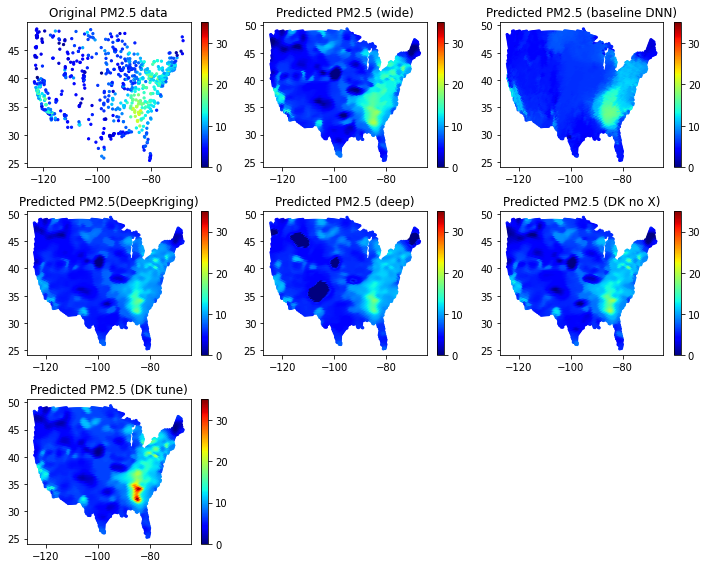

In [90]:
# 관측값과 예측값의 최소값과 최대값을 계산
vmin = 0
vmax = max(df2['PM25'].max(), PM25_pred.max(), PM25_pred_deep.max(), PM25_pred_base.max(), PM25_pred_nx.max(), PM25_pred_t.max())
s=5
cmap = 'jet'

fig, axs = plt.subplots(3, 3, figsize=(10,8))

# 원자료 시각화
sc1 = axs[0, 0].scatter(df2.values[:,1], df2.values[:,2], c=df2.values[:,3], s=s, cmap=cmap, vmin=vmin, vmax=vmax ) 
axs[0, 0].set_title('Original PM2.5 data')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('')
fig.colorbar(sc1, ax=axs[0, 0])

# PM2.5 예측값 시각화
sc2 = axs[1, 0].scatter(PM25_pred_combine[:,0], PM25_pred_combine[:,1], c=PM25_pred_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax) 
axs[1, 0].set_title('Predicted PM2.5(DeepKriging)')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('')
fig.colorbar(sc2, ax=axs[1, 0])

# 더 넓은 모형 시각화
sc3 = axs[0, 1].scatter(PM25_pred_wide_combine[:,0], PM25_pred_wide_combine[:,1], c=PM25_pred_wide_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax) 
axs[0, 1].set_title('Predicted PM2.5 (wide)')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')
fig.colorbar(sc3, ax=axs[0, 1])
    
# 더 깊은 모형 시각화
sc4 = axs[1, 1].scatter(PM25_pred_deep_combine[:,0], PM25_pred_deep_combine[:,1], c=PM25_pred_deep_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax) 
axs[1, 1].set_title('Predicted PM2.5 (deep)')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('')
fig.colorbar(sc4, ax=axs[1, 1])

# Baseline DNN 시각화
sc5 = axs[0, 2].scatter(PM25_pred_base_combine[:,0], PM25_pred_base_combine[:,1], c=PM25_pred_base_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0, 2].set_title('Predicted PM2.5 (baseline DNN)')
axs[0, 2].set_xlabel('')
axs[0, 2].set_ylabel('')
fig.colorbar(sc5, ax=axs[0, 2])

# Baseline DNN No X 시각화
sc6 = axs[1, 2].scatter(PM25_pred_nx_combine[:,0], PM25_pred_nx_combine[:,1], c=PM25_pred_nx_combine[:,2], s=s, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1, 2].set_title('Predicted PM2.5 (DK no X)')
axs[1, 2].set_xlabel('')
axs[1, 2].set_ylabel('')
fig.colorbar(sc6, ax=axs[1, 2])

# Tuner DNN 시각화
sc7 = axs[2, 0].scatter(PM25_pred_t_combine[:,0], PM25_pred_t_combine[:,1], c=PM25_pred_t_combine[:,8], s=s, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2, 0].set_title('Predicted PM2.5 (DK tune)')
axs[2, 0].set_xlabel('')
axs[2, 0].set_ylabel('')
fig.colorbar(sc7, ax=axs[2, 0])

# 남은 곳 공백으로 설정
axs[2, 1].axis('off')
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()

# 그림 외부로 저장
fig.savefig('./PM25_pred_Deep.png')

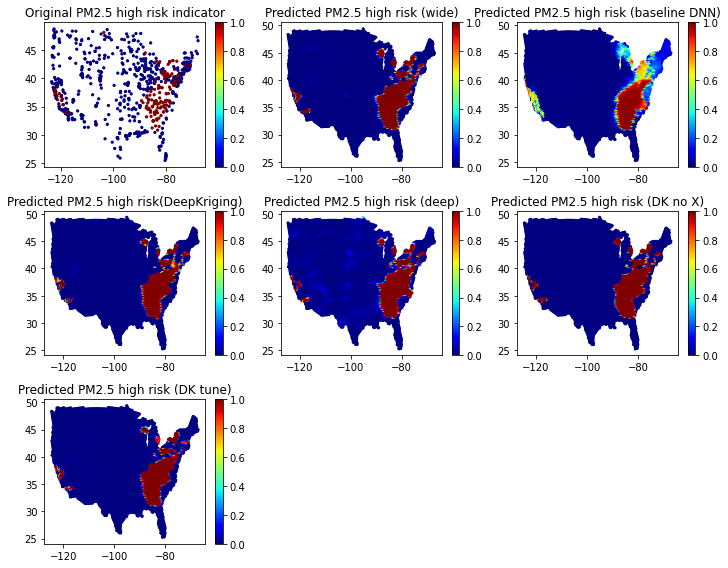

In [88]:
# Classification 결과 시각화
cmap = 'jet'
fig, axs = plt.subplots(3, 3, figsize=(10,8))

# PM2.5 class 관측값 시각화
scp1 = axs[0, 0].scatter(df2.values[:,1], df2.values[:,2], c=df2.values[:,4]-1, s=s, cmap=cmap, vmin=0, vmax=1)
        # c=df2.values[:,4]-1를 해준 이유는 PM2.5 class가 1부터 시작하기 때문에 1을 빼줌
axs[0, 0].set_title('Original PM2.5 high risk indicator')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('')
fig.colorbar(scp1, ax=axs[0, 0])

# high PM2.5 risk 예측값 시각화
scp2 = axs[1, 0].scatter(PM25_pred_class_combine[:,0], PM25_pred_class_combine[:,1], c=PM25_pred_class_combine[:,8], s=s,cmap=cmap, vmin=0, vmax=1)
axs[1, 0].set_title('Predicted PM2.5 high risk(DeepKriging)')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('')
fig.colorbar(scp2, ax=axs[1, 0])

# DeepKriging with wider hidden nodes class 예측값 시각화
scp3 = axs[0, 1].scatter(PM25_pred_wide_class_combine[:,0], PM25_pred_wide_class_combine[:,1], c=PM25_pred_wide_class_combine[:,8], s=s, cmap=cmap, vmin=0, vmax=1)
axs[0, 1].set_title('Predicted PM2.5 high risk (wide)')
axs[0, 1].set_xlabel('')
axs[1, 1].set_ylabel('')
fig.colorbar(scp3, ax=axs[0, 1])

# DeepKriging with deeper hidden layers class 예측값 시각화
scp4 = axs[1, 1].scatter(PM25_pred_deep_class_combine[:,0], PM25_pred_deep_class_combine[:,1], c=PM25_pred_deep_class_combine[:,8], s=s, cmap=cmap, vmin=0, vmax=1)
axs[1, 1].set_title('Predicted PM2.5 high risk (deep)')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('')
fig.colorbar(scp4, ax=axs[1, 1])

# Baseline DNN class 예측값 시각화
scp5 = axs[0, 2].scatter(PM25_pred_base_class_combine[:,0], PM25_pred_base_class_combine[:,1], c=PM25_pred_base_class_combine[:,8], s=s, cmap=cmap, vmin=0, vmax=1)
axs[0, 2].set_title('Predicted PM2.5 high risk (baseline DNN)')
axs[0, 2].set_xlabel('')
axs[0, 2].set_ylabel('')
fig.colorbar(scp5, ax=axs[0, 2])

# Baseline DNN No X class 예측값 시각화
scp6 = axs[1, 2].scatter(PM25_pred_nx_class_combine[:,0], PM25_pred_nx_class_combine[:,1], c=PM25_pred_nx_class_combine[:,2], s=s, cmap=cmap, vmin=0, vmax=1)
axs[1, 2].set_title('Predicted PM2.5 high risk (DK no X)')
axs[1, 2].set_xlabel('')
axs[1, 2].set_ylabel('')
fig.colorbar(scp6, ax=axs[1, 2])

# Tuner DNN class 예측값 시각화
scp7 = axs[2, 0].scatter(PM25_pred_t_class_combine[:,0], PM25_pred_t_class_combine[:,1], c=PM25_pred_t_class_combine[:,8], s=s, cmap=cmap, vmin=0, vmax=1)
axs[2, 0].set_title('Predicted PM2.5 high risk (DK tune)')
axs[2, 0].set_xlabel('')
axs[2, 0].set_ylabel('')
fig.colorbar(scp7, ax=axs[2, 0])

# 남은 곳 공백으로 설정
axs[2, 1].axis('off')
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()

# 그림 외부로 저장
fig.savefig('./PM25_pred_risk_Deep.png')

### Risk

In [81]:
# import sys
# sys.path.append('../')
# from dcdr.deep_hist import Binning_CDF
# from scipy.stats import iqr
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
# import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
# init_seed=1
# num_cut = int((max(z)-min(z))*N**(1/3)/(2*iqr(z)))
# hidden_list = [100,100,100]
# dropout_list = [0.5,0.5,0.5]
# histogram_bin = 'random'
# loss_model = 'multi-binary'
# seeding = 1

In [82]:
# import tensorflow as tf

# # GPU 설정
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # 첫 번째 GPU만 사용하도록 설정
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
#         # GPU 메모리 할당을 동적으로 조정
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#     except RuntimeError as e:
#         print(e)

In [83]:
# dcdr_model = Binning_CDF(num_cut=num_cut, hidden_list=hidden_list,
#                          histogram_bin=histogram_bin, dropout_list=dropout_list,
#                          seeding=seeding, loss_model=loss_model, 
#                          niter=10)
    
# dcdr_model.fit_cdf(inputs, targets, batch_size=32, merge_empty_bin=True)

In [84]:
# risk = dcdr_model.predict_cdf(X_RBF_pred,pred_lim=[12,12],ngrid=1)

In [85]:
# riskdf=pd.DataFrame(risk)
# riskdf.to_csv('./risk_pred.csv')